# Connect with google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load CT images & Combine CT image with csv column data as the features of the images 

In [2]:
import os
import pandas as pd
from PIL import Image
from torchvision.transforms import transforms

# Define the image transforms
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Define the path to your data folder
data_folder = "/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/Images"

# Create an empty list to store the combined data
combined_data = []

# Iterate over the subfolders in the data folder
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    
    # Load the CSV data
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            csv_path = os.path.join(folder_path, file_name)
            print(csv_path)
            csv_data = pd.read_csv(csv_path)
    
    # Load the image data and combine it with the CSV data
    i = 0
    for image_name in os.listdir(folder_path):
        if image_name.endswith(".jpg"):
            i+=1
            image_path = os.path.join(folder_path, image_name)
            image_data = Image.open(image_path).convert("RGB")
            image_data = image_transforms(image_data)
            
            # Find the corresponding row in the CSV data
            # print(csv_data[csv_data["Image Name"] == image_name])
            image_index = csv_data[csv_data["Image Name"] == image_name].index[0]
            # print(image_index)
            image_features = csv_data.iloc[image_index, 1:].values.astype(float)
            
            # Combine the image data and the CSV data
            combined_data.append((image_data, image_features))
    print(f'Number of images: {i}')

/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/Images/IPP_5%_4_0.44_1.403_0.245/IPP_5%_4_0.44_1.403_0.245.csv
Number of images: 100
/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/Images/IPP_5%_6_0.88_1.241_0.456/IPP_5%_6_0.88_1.241_0.456.csv
Number of images: 100
/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/Images/IPP_5%_8_0.97_1.399_0.613/IPP_5%_8_0.97_1.399_0.613.csv
Number of images: 100
/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/Images/IPP_10%_4_0.56_0.837_0.657/IPP_10%_4_0.56_0.837_0.657.csv
Number of images: 100
/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/Images/IPP_15%_10_1.19_1.057_1.1697/IPP_15%_10_1.19_1.057_1.1697.csv
Number of images: 100
/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/Images/IPP_20%_5_1.67_1.423_0.648/IPP_20%_5_1.67_1.423_0.648.csv
Number of images: 100
/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/Images/IPP_30%_2_2.16_1.02_0.7049/IPP_30%_2_2.16_1.02_0.7049.csv
Number of images: 100
/

In [3]:
print(len(combined_data))

3120


In [4]:
print(type(combined_data[0][0][0][0][0]))
print(combined_data[0][0][0][0][0])

<class 'torch.Tensor'>
tensor(0.4784)


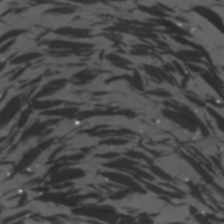

In [5]:
from torchvision.transforms import ToPILImage

# Create an instance of the ToPILImage transform
to_pil = ToPILImage()

# Reverse the image in the combined_data list to check how it look
image_tensor, image_features = combined_data[500]
image_pil = to_pil(image_tensor)
image_pil.show()


# Feature extraction from pre-train model

In [7]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import pandas as pd

# Load pre-trained ResNet model
resnet = models.resnet18(weights="IMAGENET1K_V1")

# Freeze all layers in the pre-trained model
for param in resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 100)  # 100 is the number of output features

# Define the new model to use the pre-trained ResNet18 as a feature extractor
model = torch.nn.Sequential(
    resnet,
    torch.nn.Flatten()
)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from tqdm import tqdm

def extract_features_from_combined_data(combined_data, model):
    all_features = []
    all_labels = []
    for image_data, column_data in tqdm(combined_data):

        # Extract features using model
        features = model(image_data.unsqueeze(0)).detach().numpy().flatten()

        # Add extracted features and image features to all_features list
        all_features.append(features)
        all_labels.append(column_data)

    return all_features, all_labels

# Extract features from all images in combined_data using ResNet18
all_features, all_labels = extract_features_from_combined_data(combined_data, model)


100%|██████████| 3120/3120 [04:48<00:00, 10.81it/s]


In [8]:
import numpy as np
print(len(all_features[0]))
train_features = np.vstack(all_features)
print(train_features.shape)
train_labels = np.array(all_labels)
print(np.array(all_labels).shape)
train_labels[1]

100
(3120, 100)
(3120, 7)


array([7.73204147e+01, 4.59282009e+01, 5.79903110e+02, 3.44461507e+02,
       4.40000000e-01, 2.45000000e-01, 1.40300000e+00])

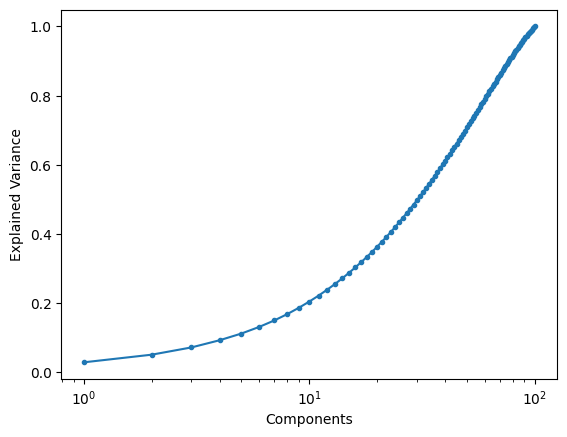

In [12]:
from sklearn import decomposition
from matplotlib import pyplot as plt

# perform the PCA embedding on image features
pca = decomposition.PCA()
z = pca.fit_transform(train_features)

# plot the explained variance of the embedding
fig, ax = plt.subplots()
_ = ax.plot(np.arange(1, 101), np.cumsum(pca.explained_variance_ratio_[:100]), '.-')
_ = ax.set_xlabel('Components')
_ = ax.set_ylabel('Explained Variance')
ax.set_xscale('log')

In [13]:
pca.explained_variance_ratio_[:10]

array([0.0292643 , 0.02206828, 0.02095846, 0.02071363, 0.01939737,
       0.01921367, 0.01869155, 0.01848833, 0.01820941, 0.01776188],
      dtype=float32)

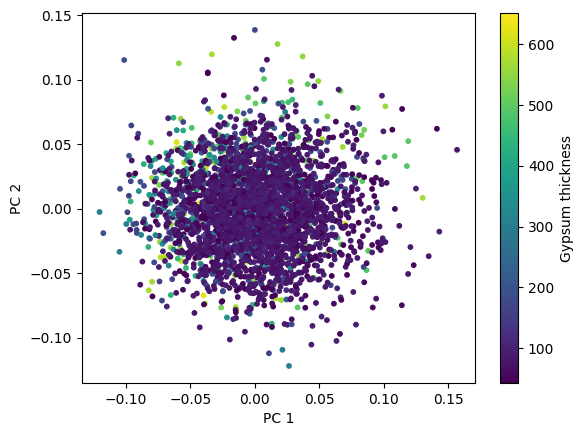

In [14]:
# plot the principal components of the image features with class labels
fig, ax = plt.subplots()
# _ = ax.scatter(*z[:, :2].T, c=train_labels[:,1])
im = ax.scatter(z[:, 0], z[:, 1], c=train_labels[:,2], s =10)
cb = plt.colorbar(im)  # save the output from colorbar
cb.set_label('Gypsum thickness')   # assign a label to the colorbar
_ = ax.set_xlabel('PC 1')
_ = ax.set_ylabel('PC 2')
ax.set_aspect('equal')

# Dataset preparation and transform into dataloader for the futher trainsfer learning

In [15]:
import torch
import numpy as np

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image, features = self.data[index]
        label = float(features[4]) # Set the label for each sample here
        return image, features, label


def custom_collate_fn(batch):
    images = []
    features = []
    labels = []
    for sample in batch:
        # Convert PyTorch tensor to NumPy array
        images.append(torch.from_numpy(sample[0].numpy()))
        features.append(torch.from_numpy(np.array(sample[1])))
        labels.append(torch.from_numpy(np.array(sample[2])))

    # Stack arrays into a single tensor
    images = torch.stack(images, dim=0).float()
    features = torch.stack(features, dim=0).float()
    labels = torch.stack(labels, dim=0).float()

    return images, features, labels


custom_dataset = CustomDataset(combined_data)

train_size = int(0.8 * len(custom_dataset))
val_size = len(custom_dataset) - train_size
torch.manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=custom_collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False, collate_fn=custom_collate_fn)



#Transfer learning

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet18 model
model = models.resnet18(weights="IMAGENET1K_V1")
# pretrained=True, `weights=ResNet18_Weights.DEFAULT

# Replace final layer to output a single value instead of classification
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 10
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    for i, (images, features, labels) in enumerate(train_loader):

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # Record training loss
        train_loss_history.append(loss.item())

        # Print training statistics
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
    
    # Evaluate the model on the validation set after each epoch
    with torch.no_grad():
        mse = 0
        for images, features, labels in val_loader:
            outputs = model(images)
            mse += criterion(outputs.squeeze(), labels).item()
        
        mse /= len(val_loader)
        val_loss_history.append(mse)
        print('Validation MSE after epoch {}: {:.4f}'.format(epoch+1, mse))


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.0MB/s]


Epoch [1/10], Step [10/250], Loss: 2.5807
Epoch [1/10], Step [20/250], Loss: 1.9988
Epoch [1/10], Step [30/250], Loss: 0.7396
Epoch [1/10], Step [40/250], Loss: 0.4032
Epoch [1/10], Step [50/250], Loss: 0.4581
Epoch [1/10], Step [60/250], Loss: 0.8224
Epoch [1/10], Step [70/250], Loss: 0.4487
Epoch [1/10], Step [80/250], Loss: 0.4793
Epoch [1/10], Step [90/250], Loss: 0.2828
Epoch [1/10], Step [100/250], Loss: 0.4961
Epoch [1/10], Step [110/250], Loss: 0.3283
Epoch [1/10], Step [120/250], Loss: 0.2961
Epoch [1/10], Step [130/250], Loss: 1.1513
Epoch [1/10], Step [140/250], Loss: 0.6317
Epoch [1/10], Step [150/250], Loss: 0.1117
Epoch [1/10], Step [160/250], Loss: 0.6602
Epoch [1/10], Step [170/250], Loss: 0.1111
Epoch [1/10], Step [180/250], Loss: 0.0719
Epoch [1/10], Step [190/250], Loss: 0.0366
Epoch [1/10], Step [200/250], Loss: 0.5151
Epoch [1/10], Step [210/250], Loss: 0.2658
Epoch [1/10], Step [220/250], Loss: 0.5021
Epoch [1/10], Step [230/250], Loss: 0.4968
Epoch [1/10], Step [

([<matplotlib.axis.XTick at 0x7f104109bb50>,
 [Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8'),
  Text(9.0, 0, '9'),
  Text(10.0, 0, '10')])

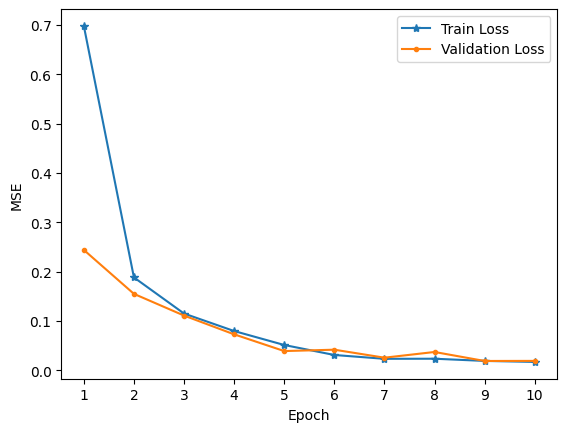

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

new_train_lis =[]
for i in range(num_epochs):
    new_train_lis.append(np.mean(train_loss_history[i*250:(i+1)*250+1]))
x = np.linspace(1,10,10)

fig, ax = plt.subplots()
ax.plot(x, new_train_lis, '*-',label='Train Loss')
ax.plot(x, val_loss_history, '.-',label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')

ax.legend()
plt.xticks(x) 

# Save trained model for the futher use without training again 

In [ ]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/model_230411_lr_1e-4_epoch_10.pt')

In [18]:
# # Load the saved model
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet18 model
model = models.resnet18(weights="IMAGENET1K_V1")

# Replace final layer to output a single value instead of classification
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 1)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/MatSE597/Project/model_230411_lr_1e-4_epoch_10.pt'))

<All keys matched successfully>

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# set model to evaluation mode
model.eval()

# create empty lists to store true labels and predictions
true_labels = []
preds = []
feature_list = []

# iterate over test set and make predictions
with torch.no_grad():
    for images, features, labels in train_loader:
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # print(outputs)
        # _, predicted = torch.max(outputs.data, 1)
        preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        feature_list.extend(features.cpu().numpy())

# convert true labels and predictions to numpy arrays
true_labels = np.array(true_labels)
preds = np.array(preds)
feature = np.array(feature_list)


In [20]:
true_val_labels = []
val_preds = []
val_feature_list = []

# iterate over test set and make predictions
with torch.no_grad():
    for images, features, labels in val_loader:
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # print(outputs)
        # _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(outputs.cpu().numpy())
        true_val_labels.extend(labels.cpu().numpy())
        val_feature_list.extend(features.cpu().numpy())

# convert true labels and predictions to numpy arrays
val_true_labels = np.array(true_val_labels)
val_preds = np.array(val_preds)
feature = np.array(val_feature_list)

# Evaluate the model

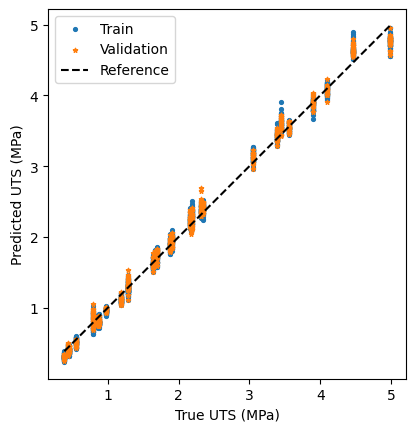

In [21]:
# plot the predictions and true label
fig, ax = plt.subplots()
ax.scatter(true_labels, preds, s=30 ,marker = '.',label='Train')
ax.scatter(val_true_labels, val_preds, s=10, marker='*', label='Validation')

min_max = np.array([true_labels.min(), true_labels.max()])
ax.plot(min_max, min_max, 'k--', label='Reference')
# cb = plt.colorbar(im)  # save the output from colorbar
# cb.set_label('thickness')   # assign a label to the colorbar
_ = ax.set_xlabel('True UTS (MPa)')
_ = ax.set_ylabel('Predicted UTS (MPa)')
ax.set_aspect('equal')
ax.legend()

In [22]:
true_labels = np.array(true_labels)
preds = np.array(preds)
preds = preds.reshape((true_labels.shape[0],))
residual = true_labels - preds
print(residual.shape)
print(true_labels.shape)
print(preds.shape)

(2496,)
(2496,)
(2496,)


In [23]:
residual = true_labels - preds
r_square = 1 - np.var(residual)/np.var(true_labels-true_labels.mean())
print(f'R-square: {r_square}')

R-square: 0.9941558144055307


In [24]:
# Extract last layer
new_model = nn.Sequential(*list(model.children())[:-1])

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model.to(device)

# set model to evaluation mode
new_model.eval()

# create empty lists to store true labels and predictions
true_labels = []
preds = []
feature_list = []
new_image = []

# iterate over test set and make predictions
with torch.no_grad():
    for images, features, labels in train_loader:
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        outputs = new_model(images)
        # print(outputs)
        # _, predicted = torch.max(outputs.data, 1)
        preds.append(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        feature_list.extend(features.cpu().numpy())
        new_image.extend(images.cpu().numpy())

latent_features = np.vstack(preds)
# latent_features = latent_features.reshape(latent_features.shape[:2])
# ft_labels = np.hstack(feature_list)

In [25]:
print(latent_features.shape)
latent_features = latent_features.reshape(latent_features.shape[:2])

(2496, 512, 1, 1)


In [26]:
new_image = np.array(new_image)
print(new_image.shape)

(2496, 3, 224, 224)


In [27]:
print(latent_features.shape)
print(len(feature_list))
ft = np.array(feature_list)
print(ft.shape)

(2496, 512)
2496
(2496, 7)


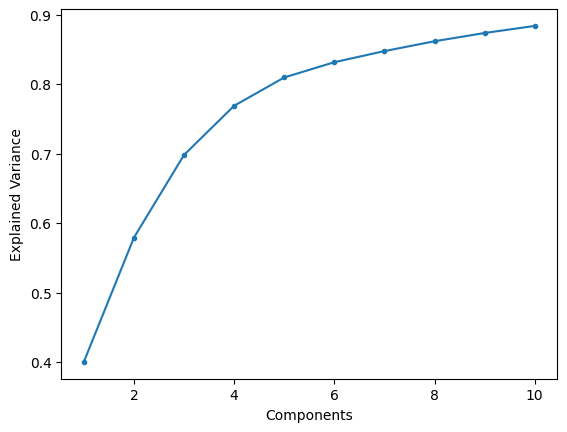

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import decomposition

# perform the PCA embedding on image features
pca = decomposition.PCA(n_components=10)
z_ft = pca.fit_transform(latent_features)

# plot the explained variance of the embedding
fig, ax = plt.subplots()
_ = ax.plot(np.arange(1, 11), np.cumsum(pca.explained_variance_ratio_[:10]), '.-')
_ = ax.set_xlabel('Components')
_ = ax.set_ylabel('Explained Variance')
# ax.set_xscale('log')

In [18]:
csv_data

,Image Name,Average White Pixels,Standard Deviation,Average Thickness(µm),Standard Deviation of Thickness,UTS (MPa),elongation at break(%),YM (GPa)
0,R_10_IPP_20%_3_0000.jpg,14.783946,4.078794,110.879594,30.590958,4.46,1.4132,1.472
1,R_10_IPP_20%_3_0016.jpg,14.120607,3.364881,105.904550,25.236608,4.46,1.4132,1.472
2,R_10_IPP_20%_3_0021.jpg,13.884592,4.214874,104.134438,31.611556,4.46,1.4132,1.472
3,R_10_IPP_20%_3_0093.jpg,12.038785,3.252902,90.290888,24.396768,4.46,1.4132,1.472
4,R_10_IPP_20%_3_0036.jpg,13.110808,3.732216,98.331058,27.991618,4.46,1.4132,1.472
...,...,...,...,...,...,...,...,...
95,R_10_IPP_20%_3_0060.jpg,12.499717,3.527510,93.747875,26.456323,4.46,1.4132,1.472
96,R_10_IPP_20%_3_0076.jpg,12.127342,3.579894,90.955067,26.849205,4.46,1.4132,1.472
97,R_10_IPP_20%_3_0071.jpg,12.416730,3.590930,93.125476,26.931972,4.46,1.4132,1.472
98,R_10_IPP_20%_3_0025.jpg,13.297756,4.591796,99.733168,34.438473,4.46,1.4132,1.472


In [29]:
print(z_ft.shape)

(2496, 10)


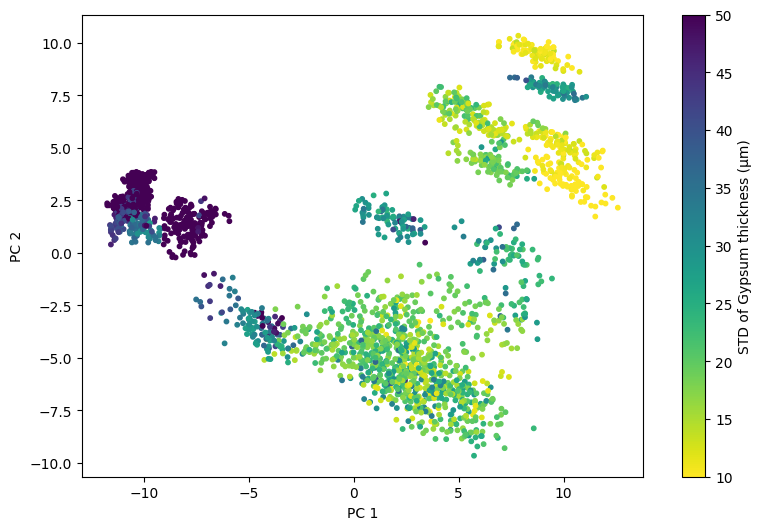

In [39]:
# plot the principal components of the image features with class labels
fig, ax = plt.subplots(figsize=(10,6))
im = ax.scatter(z_ft[:, 0], z_ft[:, 1], c=ft[:,3], s =10, vmin=10, vmax=50,cmap='viridis_r')
#  vmin=10, vmax=50, ,cmap='viridis_r'
cb = plt.colorbar(im)  # save the output from colorbar
cb.set_label('STD of Gypsum thickness (µm)')   # assign a label to the colorbar

_ = ax.set_xlabel('PC 1')
_ = ax.set_ylabel('PC 2')
ax.set_aspect('equal')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


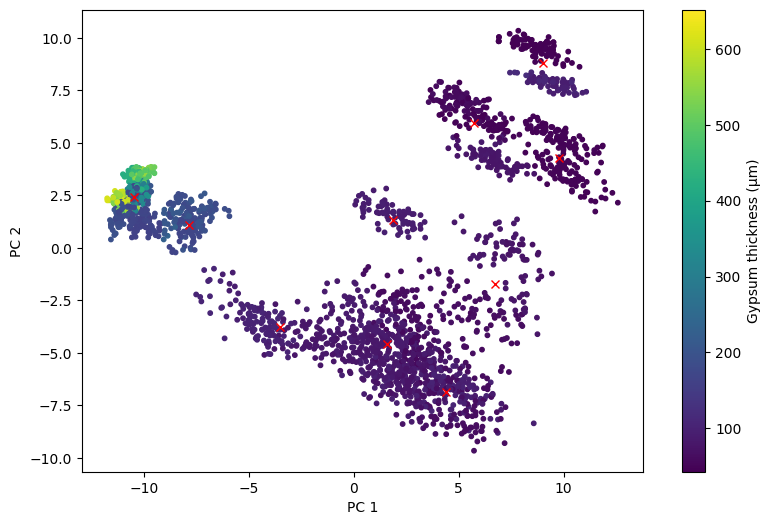

In [31]:
from sklearn import cluster

# perform the clustering
km = cluster.KMeans(n_clusters=10, random_state=0).fit(z_ft[:, :2])
centers = km.cluster_centers_

# determine which sample IDs are closest to the cluster centers
center_id = []
for i in range(km.n_clusters):
    this_id = np.argmin(np.linalg.norm(centers[i]- z_ft[:, :2], axis=1))
    center_id.append(this_id)

# plot the cluster centers
_ = ax.plot(*km.cluster_centers_.T, 'rx')
fig

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


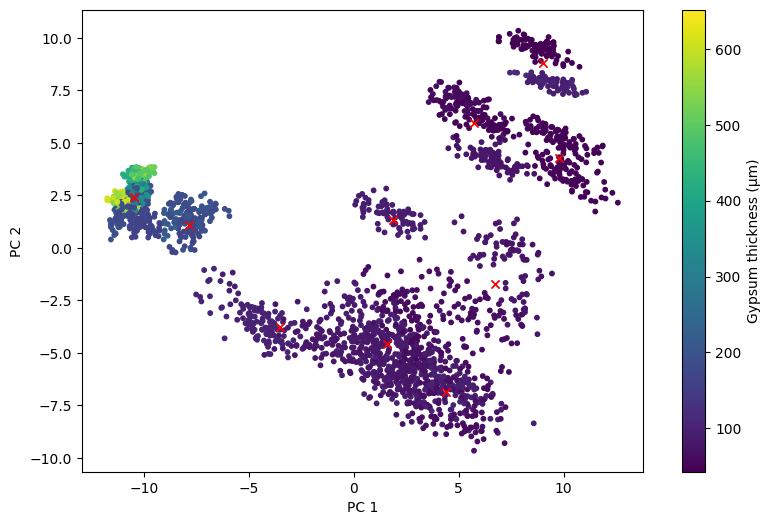

In [32]:
from sklearn import cluster

# perform the clustering
km = cluster.KMeans(n_clusters=10, random_state=0).fit(z_ft[:, :2])

# determine which sample IDs are closest to the cluster centers
center_id = []
for i, c in enumerate(km.cluster_centers_):
    dist = np.linalg.norm(c - z_ft[:, :2], axis=1)
    center_id.append( np.argmin(dist) )

# plot the cluster centers
_ = ax.plot(*km.cluster_centers_.T, 'rx')
fig

In [33]:
center_id 

[110, 355, 2349, 2280, 542, 1685, 1970, 249, 1886, 1897]

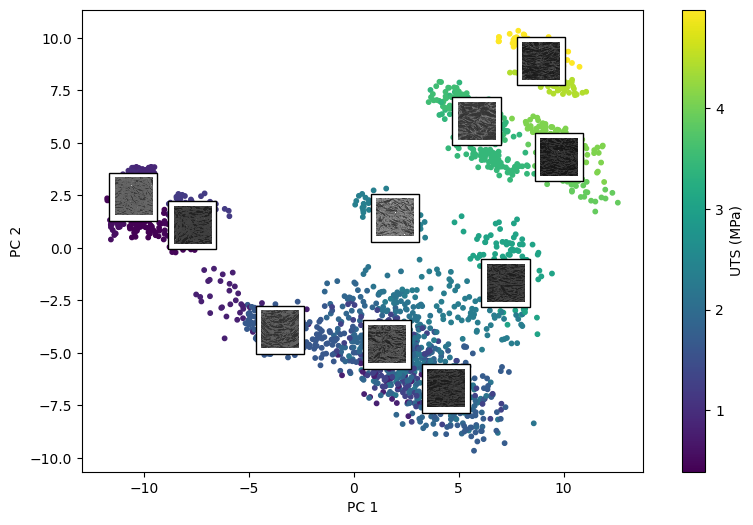

In [36]:
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.scatter(z_ft[:, 0], z_ft[:, 1], c=ft[:,4], s =10)
cb = plt.colorbar(im)
cb.set_label('UTS (MPa)')
_ = ax.set_xlabel('PC 1')
_ = ax.set_ylabel('PC 2')
ax.set_aspect('equal')

thumbnail_size = (64, 64)
for id in center_id:
    img_tensor = new_image[id]
    img = img_tensor.transpose()
    img_rotated = np.rot90(img, k=1) # rotate image 90 degrees
    image_offset = OffsetImage(img_rotated, zoom=0.12)
    ab = AnnotationBbox(image_offset, z_ft[id, :2], xycoords='data')
    ax.add_artist(ab)


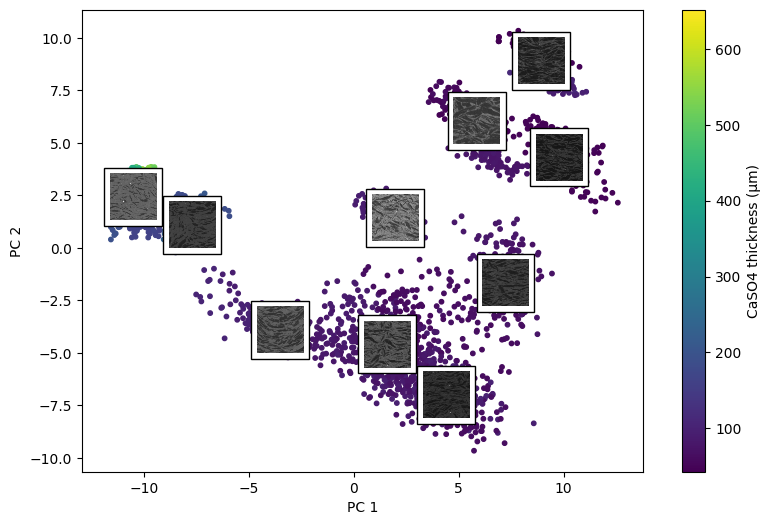

In [39]:
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.scatter(z_ft[:, 0], z_ft[:, 1], c=ft[:,2], s =10)
cb = plt.colorbar(im)
cb.set_label('Gypsum thickness (µm)')
_ = ax.set_xlabel('PC 1')
_ = ax.set_ylabel('PC 2')
ax.set_aspect('equal')

thumbnail_size = (64, 64)
for id in center_id:
    img_tensor = new_image[id]
    img = img_tensor.transpose()
    img_rotated = np.rot90(img) # rotate image 90 degrees
    image_offset = OffsetImage(img_rotated, zoom=0.15)
    ab = AnnotationBbox(image_offset, z_ft[id, :2], xycoords='data')
    ax.add_artist(ab)

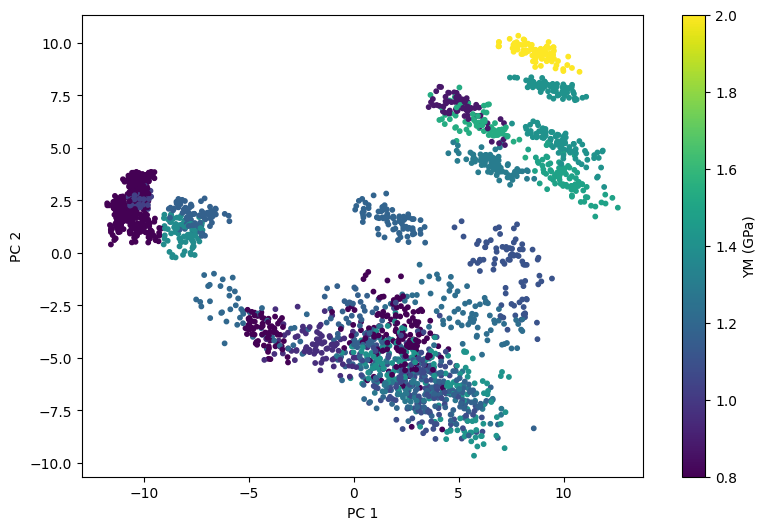

In [ ]:
# plot the principal components of the image features with class labels
fig, ax = plt.subplots(figsize=(10,6))
im = ax.scatter(z_ft[:, 0], z_ft[:, 1], c=ft[:,5], s =10, vmin=0.8, vmax=2) # cmap='viridis_r'
cb = plt.colorbar(im)  # save the output from colorbar
cb.set_label('YM (GPa)')   # assign a label to the colorbar

# _ = ax.scatter(*z_ft[:, :2].T, c=ft[:,2])
# im = ax.scatter(z[:, 0], z[:, 1], c=train_labels[:,2], s =10)
# cb = plt.colorbar(im)  # save the output from colorbar
# cb.set_label('thickness')   # assign a label to the colorbar
_ = ax.set_xlabel('PC 1')
_ = ax.set_ylabel('PC 2')
ax.set_aspect('equal')

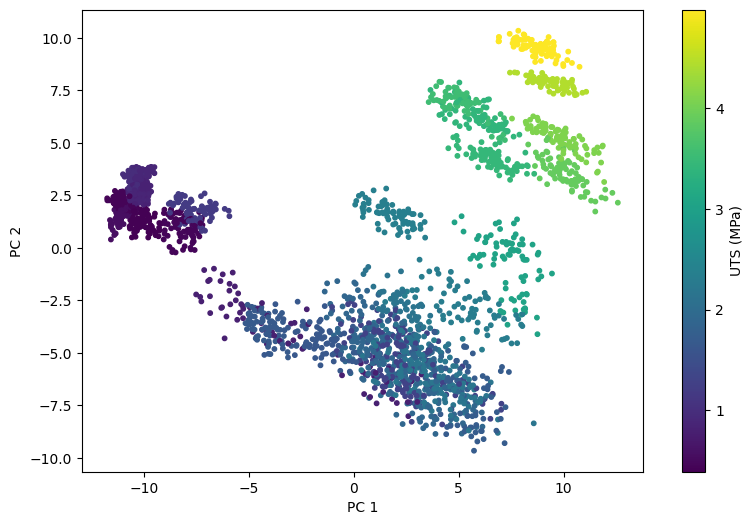

In [ ]:
# plot the principal components of the image features with class labels
fig, ax = plt.subplots(figsize=(10,6))
im = ax.scatter(z_ft[:, 0], z_ft[:, 1], c=ft[:,4], s =10)
cb = plt.colorbar(im)  # save the output from colorbar
cb.set_label('UTS (MPa)')   # assign a label to the colorbar

# _ = ax.scatter(*z_ft[:, :2].T, c=ft[:,2])
# im = ax.scatter(z[:, 0], z[:, 1], c=train_labels[:,2], s =10)
# cb = plt.colorbar(im)  # save the output from colorbar
# cb.set_label('thickness')   # assign a label to the colorbar
_ = ax.set_xlabel('PC 1')
_ = ax.set_ylabel('PC 2')
ax.set_aspect('equal')